In [25]:
from sklearn.cluster import KMeans
import os
import pandas as pd
from obp.dataset import OpenBanditDataset
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPW
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib as plt

In [30]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset_cluster_1.n_actions, 
    len_list=dataset_cluster_1.len_list, 
    campaign="men",
    random_state=12345,
    policy_name = "random"
)

# compute the action choice probabilities of the evaluation policy via Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [31]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

In [33]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

In [34]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

In [36]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

In [37]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

# Loop para clusters automáticos 

Para generar clusters necesitamos sobreescribir el dataset de zozotwon con la subdivisión que corresponda... 

In [12]:
def get_bandit_dataset(behavior_policy, campaign, data_path, dataset_name):
    dataset_cluster = OpenBanditDataset(behavior_policy=behavior_policy, campaign=campaign, data_path=data_path, dataset_name=dataset_name)
    return dataset_cluster

In [13]:
# behavior_policy = random, campaing = men, datapath = open_bandit_dataset
def get_bandit_feedback(behavior_policy, campaign, data_path, dataset_name):
    dataset_cluster = get_bandit_dataset(behavior_policy, campaign, data_path, dataset_name)
    bandit_feedback = dataset_cluster.obtain_batch_bandit_feedback()
    return bandit_feedback

In [14]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
def make_regression_model(dataset):
    regression_model = RegressionModel(
        n_actions=dataset.n_actions,
        len_list=dataset.len_list,
        action_context=dataset.action_context,
        base_model=LogisticRegression(max_iter=1000, random_state=12345),
    )
    return regression_model

## Data Loading and Preprocessing

In [31]:
n_clusters = 2

# Importar dataset original desde una copia: 'men_copy.csv'
path = os.path.join("open_bandit_dataset", "random", "men", "men_copy.csv")
dataset = pd.read_csv(path,  index_col=0) # por ahora solo se utilizan datos 'men', 'random'

full_dataset = dataset.copy()

# Clusterizar el dataser original 
dataset.drop(columns=["item_id", "position", "click", "propensity_score", "timestamp", "user_feature_0", "user_feature_1", "user_feature_2", "user_feature_3"], inplace= True)
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, random_state=12345)
predict = kmeans.fit_predict(dataset)

full_dataset['clusters'] = predict

cluster_datasets = []
cluster_results = []

# Aplicar una mascara al dataset para filtrar por cluster
for i in range(n_clusters): 
    print(i)
    cluster_datasets.append(full_dataset.loc[full_dataset['clusters'] == i])

# Iteracion principal para sobreescribir csv de OBP
for i in range(n_clusters):
    path = os.path.join("open_bandit_dataset", "random", "men", "men.csv")
    dataset = cluster_datasets[i]
    dataset.to_csv(path, index=False)

    # compute the action choice probabilities of the evaluation policy via Monte Carlo simulation
    # bandit_feedback = get_bandit_feedback(
    #     behavior_policy = 'random', 
    #     campaign = 'men', 
    #     datapath = 'open_bandit_dataset'
    # )

    dataset = OpenBanditDataset(behavior_policy="random", campaign="men", data_path="open_bandit_dataset", dataset_name="men.csv")
    bandit_feedback = dataset.obtain_batch_bandit_feedback()

    ######### Aqui aplicar simulacion y estimacion sobre clusters ###########
    evaluation_policy = BernoulliTS(
        n_actions=dataset.n_actions, 
        len_list=dataset.len_list, 
        campaign="men",
        random_state=12345,
        policy_name = "random"
    )

    regression_model = RegressionModel(
        n_actions=dataset.n_actions,
        len_list=dataset.len_list,
        action_context=dataset.action_context,
        base_model=LogisticRegression(max_iter=1000, random_state=12345),
    )

    estimated_rewards_by_reg_model = regression_model.fit_predict(
        context=bandit_feedback["context"],
        action=bandit_feedback["action"],
        reward=bandit_feedback["reward"],
        position=bandit_feedback["position"],
        pscore=bandit_feedback["pscore"],
        n_folds=3, # use 3-fold cross-fitting
        random_state=12345,
    )
    
    action_dist = evaluation_policy.compute_batch_action_dist(
        n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
    )

    # estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
    ope = OffPolicyEvaluation(
        bandit_feedback=bandit_feedback,
        ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
    )
    

    # `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
    estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
        action_dist=action_dist, 
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
        n_bootstrap_samples=10000, # number of resampling performed in bootstrap sampling.
        random_state=12345,
    )

    cluster_results.append(estimated_policy_value)


0
1


In [17]:
cluster_results[0]

,estimated_policy_value,relative_estimated_policy_value
ipw,0.005033,0.998931
dm,0.005050,1.002412
dr,0.005030,0.998277


In [18]:
cluster_results[1]

,estimated_policy_value,relative_estimated_policy_value
ipw,0.015895,1.000256
dm,0.016157,1.016764
dr,0.015940,1.003093


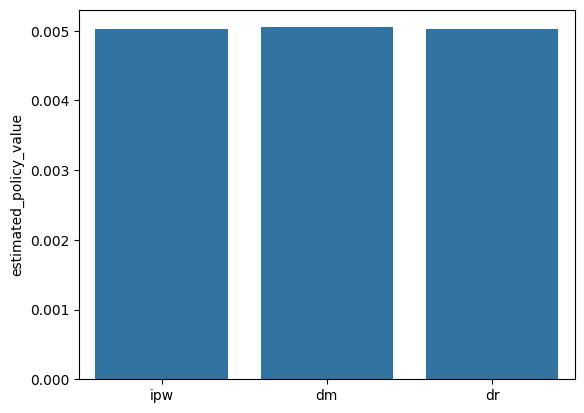

In [27]:
plot = sns.barplot(cluster_results[0]['estimated_policy_value'])
fig = plot.get_figure()
fig.savefig("cluster0.png")

<Axes: ylabel='estimated_policy_value'>

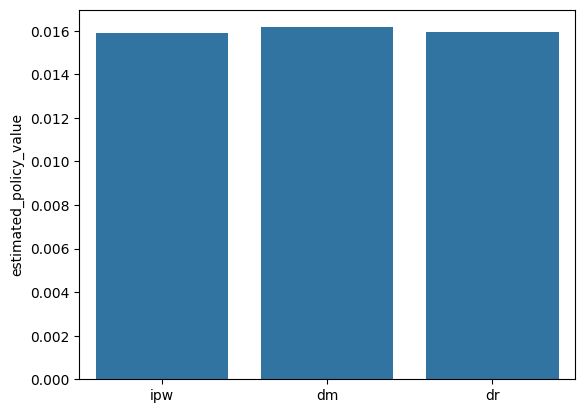

In [23]:
sns.barplot(cluster_results[1]['estimated_policy_value'])

In [28]:
cluster_results_2 = cluster_results

## Replicating Production Policy

In [ ]:
# define BernoulliTS as an evaluation policy
def get_bernoulliTS_from_cluster(cluster):
    evaluation_policy = BernoulliTS(
        n_actions=cluster.n_actions, 
        len_list=cluster.len_list, 
        campaign="men",
        random_state=12345,
        policy_name = "random"
    )

    # compute the action choice probabilities of the evaluation policy via Monte Carlo simulation
    action_dist = evaluation_policy.compute_batch_action_dist(
        n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
    )

    return evaluation_policy, action_dist